In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm  #to get loading screen
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img # load image directly to numpy array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

2024-04-24 10:06:46.011511: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 10:06:46.011674: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 10:06:46.164505: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# load dataset|
directory = '../input/utkface-new/UTKFace/'

In [4]:
# image labels contain age, gender and ethnicity
image_paths = []
age_labels = []
gender_labels = []

for fname in tqdm(os.listdir(directory)):
    image_path = os.path.join(directory, fname)
    temp = fname.split('_')  # splitting img name using underscore
    age = int(temp[0])
    gender = int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

In [5]:
# convert to dataframe
data = pd.DataFrame({'image': image_paths, 'age': age_labels, 'gender': gender_labels})
data.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [6]:
# map labels for gender
gender_dictionary = {0:'Male', 1:'Female'}

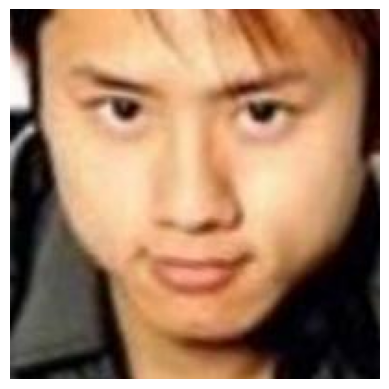

In [9]:
# Analyze data
from PIL import Image
img = Image.open(data['image'][0])
plt.axis('off') # remove axes
plt.imshow(img);

(array([3413., 2631., 9063., 3141., 2688., 1400.,  854.,  446.,   54.,
          18.]),
 array([  1. ,  12.5,  24. ,  35.5,  47. ,  58.5,  70. ,  81.5,  93. ,
        104.5, 116. ]),
 <BarContainer object of 10 artists>)

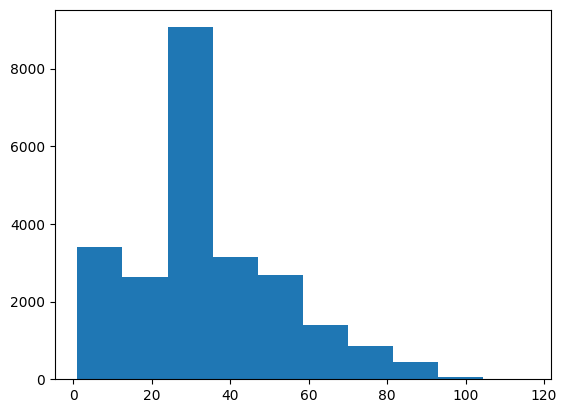

In [10]:
plt.hist(data['age'])

<Axes: xlabel='age', ylabel='Density'>

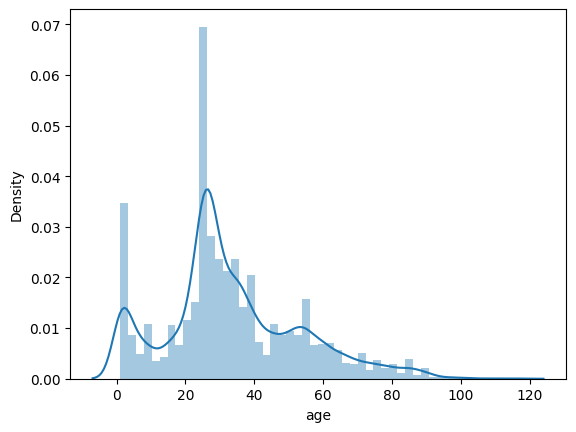

In [11]:
sns.distplot(data['age'])

(array([12391.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 11317.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

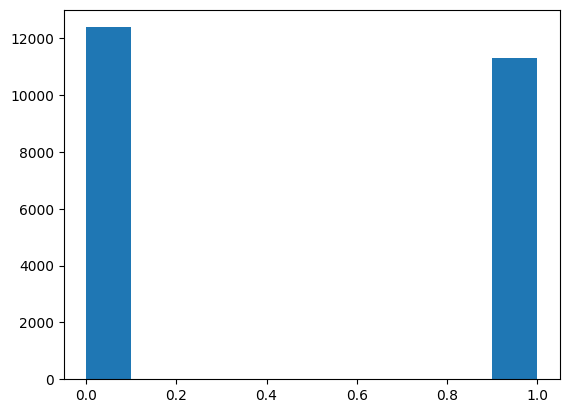

In [12]:
plt.hist(data['gender'])

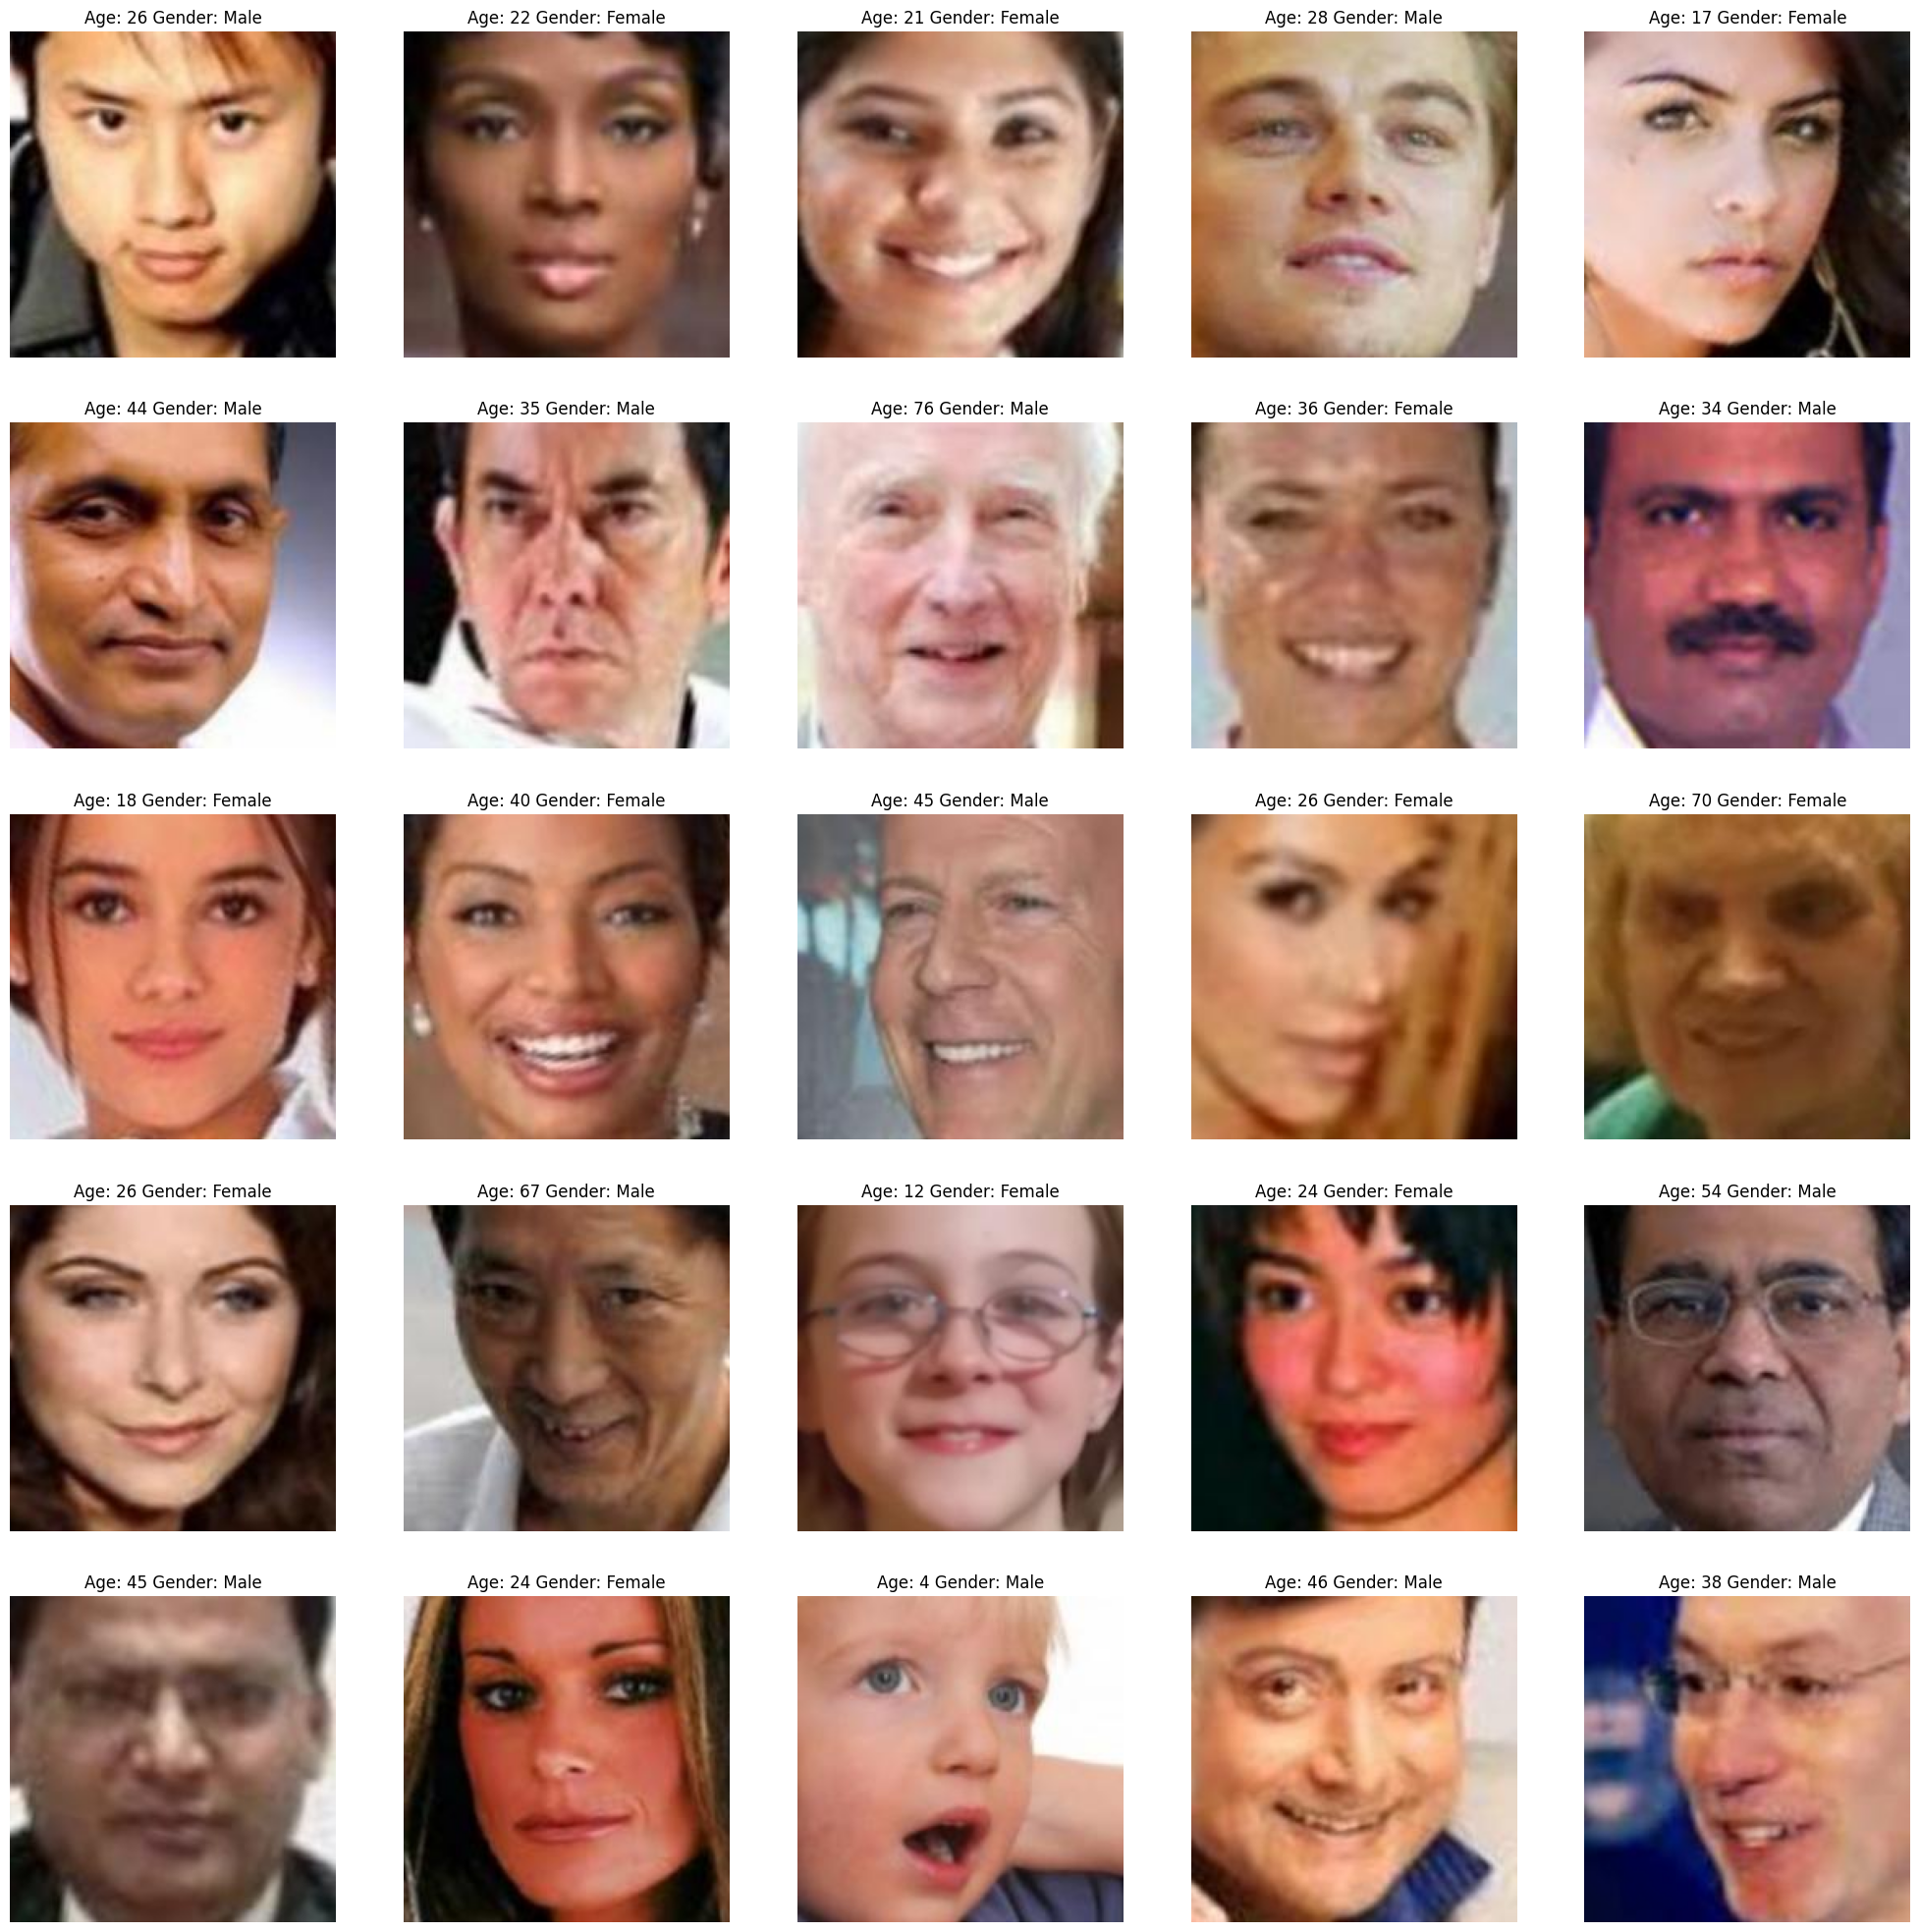

In [13]:
# display images
plt.figure(figsize=(25,25))
files = data.iloc[0:25]

for index, file, age, gender in files.itertuples():
    plt.subplot(5,5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f'Age: {age} Gender: {gender_dictionary[gender]}')
    plt.axis('off')

In [19]:
# extract features
def img_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode='grayscale')  # convert to grayscale 
        img = img.resize((128,128), Image.ANTIALIAS) # ANTIALIAS used to avoid distortions
        img = np.array(img) # Convert image to numpy array
        features.append(img)
    
    features = np.array(features)
    # 128 represents dimension (width & height) and 1 represents grayscale
    features = features.reshape(len(features), 128, 128, 1)
    # if rgb img use 3 instead of 1
    return features

In [20]:
x = img_features(data['image'])

  0%|          | 0/23708 [00:00<?, ?it/s]

In [21]:
x.shape

(23708, 128, 128, 1)

In [22]:
# normalize images 
x = x/255.0  # because pixels are in range 0-255

In [26]:
y_gender = np.array(data['gender'])
y_age = np.array(data['age'])

In [27]:
input_shape = (128,128,1)

In [46]:
# Create model
inputs = Input((input_shape))
# convolutional layers
conv_1 = Conv2D(32, kernel_size=(3,3), activation='relu')(inputs) # 32 filter
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3,3), activation='relu')(maxp_1) # 64 filter
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3,3), activation='relu')(maxp_2) # 128 filter
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3,3), activation='relu')(maxp_3) # 256 filter
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

# convolutional layers have weights in matrix structure. flatten can convert these into single dimension vectors
flatten = Flatten()(maxp_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

# regularization
dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

# output layers for gender and age
output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

# for regression(age prediction) Mean Abs Error(mae) can be used for both loss and metric
# for gender classification binarycrossentropy is the loss and accuracy is the metric
model.compile(loss=['binary_crossentropy', 'mae'], optimizer='adam', metrics=[['accuracy'], ['mae']])

In [47]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 126, 126,  │        320 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_20    │ (None, 63, 63,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 61, 61,    │     18,496 │ max_pooling2d_20… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_21    │ (None, 30, 30,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │     73,856 │ max_pooling2d_21… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_22    │ (None, 14, 14,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 12, 12,    │    295,168 │ max_pooling2d_22… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_23    │ (None, 6, 6, 256) │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 9216)      │          0 │ max_pooling2d_23… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 256)       │  2,359,552 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 256)       │  2,359,552 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ dense_10[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ dense_11[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gender_out (Dense)  │ (None, 1)         │        257 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ age_out (Dense)     │ (None, 1)         │        257 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,107,458 (19.48 MB)

 Trainable params: 5,107,458 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# train model
pred_model = model.fit(x=x, y=[y_gender, y_age], batch_size=32, epochs=15, validation_split=0.2)

Epoch 1/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 248s 418ms/step - age_out_mae: 5.4035 - gender_out_accuracy: 0.9178 - loss: 5.6037 - val_age_out_mae: 6.5613 - val_gender_out_accuracy: 0.8893 - val_loss: 6.8193
Epoch 2/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 259s 414ms/step - age_out_mae: 5.1272 - gender_out_accuracy: 0.9186 - loss: 5.3211 - val_age_out_mae: 6.5379 - val_gender_out_accuracy: 0.8851 - val_loss: 6.8059
Epoch 3/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 264s 417ms/step - age_out_mae: 5.0716 - gender_out_accuracy: 0.9242 - loss: 5.2529 - val_age_out_mae: 7.1290 - val_gender_out_accuracy: 0.8855 - val_loss: 7.3946
Epoch 4/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 261s 415ms/step - age_out_mae: 4.9586 - gender_out_accuracy: 0.9263 - loss: 5.1249 - val_age_out_mae: 6.6455 - val_gender_out_accuracy: 0.8844 - val_loss: 6.9347
Epoch 5/15
593/593 ━━━━━━━━━━━━━━━━━━━━ 250s 422ms/step - age_out_mae: 4.6507 - gender_out_accuracy: 0.9294 - loss: 4.8156 - val_age_out_mae: 6.5598 - val_gender_out_accuracy: 0.8897 - val_los

<Figure size 640x480 with 0 Axes>

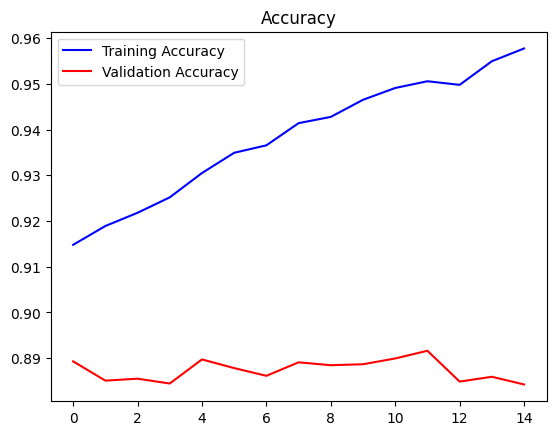

<Figure size 640x480 with 0 Axes>

In [52]:
acc = pred_model.history['gender_out_accuracy']
val_acc = pred_model.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.figure()



In [ ]:
model.save('my_model.h5')